max_context_len =  16
h_real_samples =  (8, 500)
corrh0 =  (8, 8)
corr_0 =  [[ 1.00000000e+00  9.38348033e-01  7.64747896e-01  5.10945491e-01
   0.00000000e+00 -2.84060969e-17 -5.57279917e-17 -7.97972799e-17]
 [ 9.38348033e-01  8.82373948e-01  7.24646762e-01  4.93679300e-01
   0.00000000e+00 -1.40946282e-17 -7.63278329e-17 -5.87637577e-17]
 [ 7.64747896e-01  7.24646762e-01  6.11305352e-01  4.44229368e-01
   0.00000000e+00 -1.40946282e-17 -3.02492406e-17 -6.00648004e-17]
 [ 5.10945491e-01  4.93679300e-01  4.44229368e-01  3.69244082e-01
   0.00000000e+00  1.44198889e-17  7.86046575e-18 -2.65629532e-18]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-2.84060969e-17 -1.45283091e-17 -1.08420217e-17  1.09639945e-17
   0.00000000e+00  1.17626052e-01  2.13701271e-01  2.71068596e-01]
 [-5.57279917e-17 -6.33174069e-17 -3.00324002e-17  1.11266248e-17
   0.00000000e+00  2.13701271e-01  3.88694648e-01  4.9411866

  7%|▋         | 1/15 [00:03<00:42,  3.01s/it]

# examples = 0, CU_x_MSE = 0.9609719922801147


 13%|█▎        | 2/15 [00:06<00:43,  3.32s/it]

# examples = 1, CU_x_MSE = 0.8394457395268637


 20%|██        | 3/15 [00:12<00:52,  4.37s/it]

# examples = 2, CU_x_MSE = 0.7540220697481579


 27%|██▋       | 4/15 [00:19<01:00,  5.52s/it]

# examples = 3, CU_x_MSE = 0.7038889368930608


 33%|███▎      | 5/15 [00:28<01:09,  6.95s/it]

# examples = 4, CU_x_MSE = 0.6772225173917608


 40%|████      | 6/15 [00:39<01:14,  8.29s/it]

# examples = 5, CU_x_MSE = 0.6751340486085716


 47%|████▋     | 7/15 [00:52<01:17,  9.67s/it]

# examples = 6, CU_x_MSE = 0.6793970103697964


 53%|█████▎    | 8/15 [01:07<01:20, 11.43s/it]

# examples = 7, CU_x_MSE = 0.650292106212151


 60%|██████    | 9/15 [01:24<01:18, 13.01s/it]

# examples = 8, CU_x_MSE = 0.6351584684202729


 67%|██████▋   | 10/15 [01:45<01:18, 15.77s/it]

# examples = 9, CU_x_MSE = 0.6405796263771208


 73%|███████▎  | 11/15 [02:08<01:11, 17.89s/it]

# examples = 10, CU_x_MSE = 0.6300434209651097


 80%|████████  | 12/15 [02:32<00:59, 19.71s/it]

# examples = 11, CU_x_MSE = 0.6312217090468926


 87%|████████▋ | 13/15 [03:00<00:44, 22.09s/it]

# examples = 12, CU_x_MSE = 0.6141127636843798


 93%|█████████▎| 14/15 [03:31<00:24, 24.90s/it]

# examples = 13, CU_x_MSE = 0.6350007536387293


100%|██████████| 15/15 [04:07<00:00, 16.53s/it]

# examples = 14, CU_x_MSE = 0.6343013316818779



  7%|▋         | 1/15 [00:01<00:21,  1.51s/it]

# examples = 0, CU_x_MSE = 1.5118616305587596


 13%|█▎        | 2/15 [00:03<00:24,  1.87s/it]

# examples = 1, CU_x_MSE = 1.2443813938855213


 20%|██        | 3/15 [00:07<00:34,  2.86s/it]

# examples = 2, CU_x_MSE = 1.1047117550704941


 27%|██▋       | 4/15 [00:13<00:42,  3.86s/it]

# examples = 3, CU_x_MSE = 1.014889097663449


 33%|███▎      | 5/15 [00:21<00:53,  5.40s/it]

# examples = 4, CU_x_MSE = 0.9419318870803473


 40%|████      | 6/15 [00:31<01:03,  7.11s/it]

# examples = 5, CU_x_MSE = 0.9128938888831821


 47%|████▋     | 7/15 [00:44<01:11,  8.91s/it]

# examples = 6, CU_x_MSE = 0.8745884256967287


 53%|█████▎    | 8/15 [00:59<01:17, 11.01s/it]

# examples = 7, CU_x_MSE = 0.8392869528614832


 60%|██████    | 9/15 [01:18<01:19, 13.32s/it]

# examples = 8, CU_x_MSE = 0.8111136682062583


 67%|██████▋   | 10/15 [01:38<01:18, 15.62s/it]

# examples = 9, CU_x_MSE = 0.8098787716524536


 73%|███████▎  | 11/15 [02:02<01:12, 18.12s/it]

# examples = 10, CU_x_MSE = 0.8165859794768249


 80%|████████  | 12/15 [02:31<01:03, 21.25s/it]

# examples = 11, CU_x_MSE = 0.7988039406041355


 87%|████████▋ | 13/15 [03:03<00:49, 24.72s/it]

# examples = 12, CU_x_MSE = 0.7671009994344552


 93%|█████████▎| 14/15 [03:43<00:29, 29.12s/it]

# examples = 13, CU_x_MSE = 0.7578867147678245


100%|██████████| 15/15 [04:26<00:00, 17.78s/it]

# examples = 14, CU_x_MSE = 0.7562994580930856


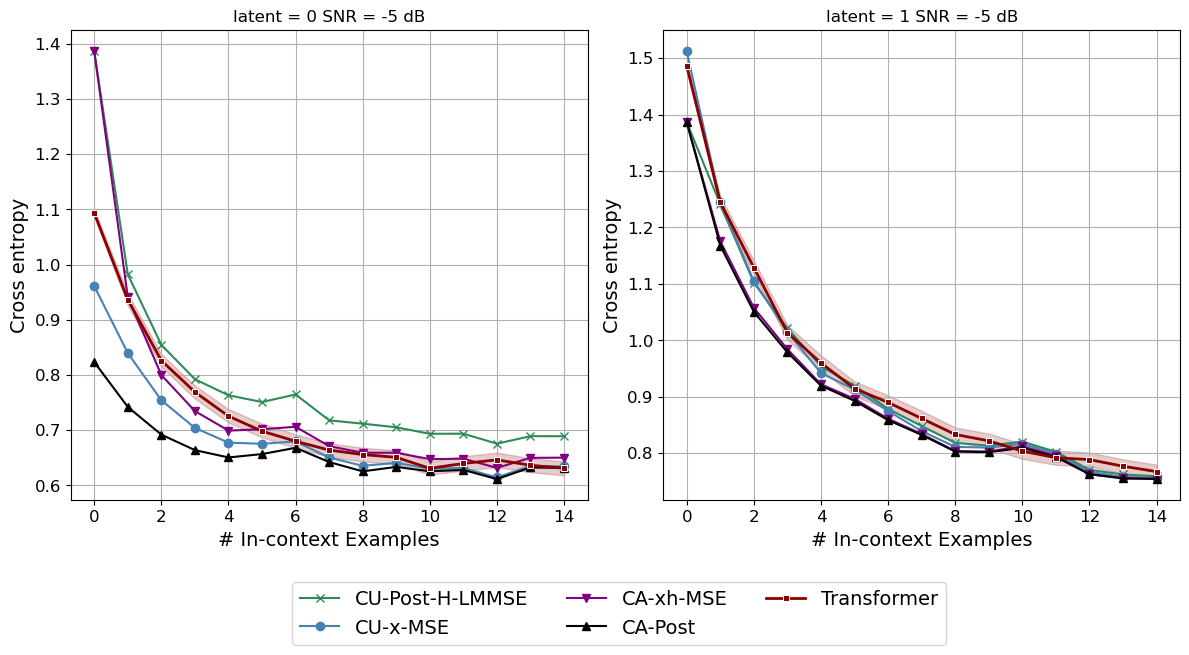

In [18]:
from matplotlib.patches import bbox_artist
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import seaborn as sns
import torch
import math

def get_herm(array, axis1=-1, axis2=-2):
    return np.conjugate(np.swapaxes(array, axis1, axis2))

def get_h_one_ray(batch_size, d):
    alphas = np.random.rand(batch_size)*np.pi
    return np.expand_dims(np.exp(-1j*np.outer(np.cos(alphas), np.arange(d))/ 2), axis=1) # (batch_size, 1, d) shape

def get_h_partition_one_ray(n_pts, d):
    return np.exp(-1j*np.outer(np.arange(d), np.cos(np.linspace(0,np.pi,n_pts)))/ 2)
    

def get_likelihoods(curr_out, 
                    past_out_symbs, 
                    past_in_symbs, 
                    X, 
                    SNR_dB=-5, 
                    latent=1, 
                    n_pts=500,
                    d=4):
    """
    past_out_symbs: complex valued past out symbols of size batchsize, k, d
    past_in_symbs: complex valued past in symbols of size batchsize, k, 1
    curr_out: complex valued curr in symbols of size batchsize, d
    X: in symbol set (QPSK)
    SNR_dB: 1/sigma2 in dB
    latent: underlying context theta in {0, 1}
    n_pts: n_pts for numerical integral eval when latent=0
    """
    sigma2 = 10**(-SNR_dB/10)
    likelihood_mass = np.zeros((len(curr_out), len(X)))
    batch_size = len(curr_out)
    # print('past_in_symb = ', past_in_symbs.shape)
    # print('latent = ', latent)

    

    any_past = past_in_symbs.any()
    # print('past? ', any_past)
    
    k = len(past_out_symbs[0]) if any_past else 0
    
    if latent==0:
        # latent context is one-ray returns a alphas
        h = get_h_partition_one_ray(n_pts=n_pts, d=d)  # d_alpha for alpha corresponding to each of n_pts equally spaced points in (0, pi)
        if any_past:
            past_in_symbs = np.expand_dims(past_in_symbs, axis=3)
            past_out_symbs = np.expand_dims(past_out_symbs, axis=3)
            sq_dist_past_symbs = np.sum(np.abs(past_out_symbs-past_in_symbs * h)**2, axis=(1,2))
        else:
            sq_dist_past_symbs = 0
        curr_out = np.expand_dims(curr_out, axis=2)
        for idx, x_real_vec in enumerate(X):
            x = x_real_vec[0] + 1j* x_real_vec[1]
            curr_in = np.tile(x, (batch_size, 1, 1))
            sq_dist_curr_symb = np.sum(np.abs(curr_out-curr_in * h)**2, axis=1)
            net_sq_dist = sq_dist_past_symbs + sq_dist_curr_symb
            likelihood_mass[:, idx] = np.sum(np.exp(-net_sq_dist/(2*sigma2)), axis=-1) / n_pts / (sigma2**(d*(k+1)))
    else:
        
        sigma2 = 10**(-SNR_dB/10)
        channel_power = 1/2
        # corr_h = np.sqrt(channel_power) * np.eye(2*d)
        # corr_h = np.tile(corr_h, (batchsize, 1, 1))

        curr_out = np.expand_dims(curr_out, axis=1)
        if any_past:
            out_symbs = np.concatenate((past_out_symbs, curr_out), axis=1)
        else:
            out_symbs = curr_out

        # convert to real-valued
        out_symbs_real_mat = complex_to_real_mat(out_symbs)
        out_symbs_real_vec = out_symbs_real_mat.reshape(len(out_symbs_real_mat), -1, 1)  # yk (batchsize, 2kd, 1)
        out_symbs_real_vec_T = out_symbs_real_vec.swapaxes(-1, -2)

        out_vec_dim = len(out_symbs_real_vec[0])
        batchsize = len(out_symbs_real_vec)

        for idx, x_real_vec in enumerate(X):
            x = x_real_vec[0] + 1j* x_real_vec[1]
            curr_in = np.tile(x, (batch_size, 1, 1))
            if any_past:
                in_symbs = np.concatenate((past_in_symbs, curr_in), axis=1)
            else:
                in_symbs = curr_in

            in_symbs_real_mat = get_in_mat(in_symbs, d)  # (batchsize, 2kd, 2d)  Xk
            in_symbs_real_mat_T = np.swapaxes(in_symbs_real_mat, axis1=-1, axis2=-2) # (batchsize, 2d, 2kd) Xk.T
            eye_mat = np.eye(out_vec_dim).reshape(1,out_vec_dim,-1)

            corr_out = channel_power * in_symbs_real_mat @ in_symbs_real_mat_T + sigma2*eye_mat
            corr_out_inv = np.linalg.inv(corr_out)
            dim = len(corr_out)

            likelihood_mass[:, idx] =  1/np.sqrt(np.abs(np.linalg.det(corr_out))) * np.exp(-1/2* (out_symbs_real_vec_T @ corr_out_inv @ out_symbs_real_vec).squeeze())

            # cross_corr = corr_h @ in_symbs_real_mat_T

            # mean_out = in_symbs_real_mat @ mean_h
            # mean_h_vec = mean_h.reshape(1,-1, 1)
            # mean_out_vec = np.expand_dims(mean_out, axis=-1)
            # mean_out_vec_T = mean_out_vec.swapaxes(-1, -2)
            # cov_out = corr_out - mean_out_vec @ mean_out_vec_T
            # cov_out_inv = np.linalg.inv(cov_out)
            # cross_corr = corr_h @ in_symbs_real_mat_T
            # cross_cov = cross_corr-mean_h_vec @ mean_out_vec_T

        # print('corr_h = ', corr_h)
        

        # curr_out = np.expand_dims(curr_out, axis=1)
        # if any_past:
        #     out_symbs = np.concatenate((past_out_symbs, curr_out), axis=1)
        # else:
        #     out_symbs = curr_out
        # out_symbs_herm = get_herm(array=out_symbs, axis1=-1, axis2=-2)
        # # print('out_symbs = ', out_symbs.shape)
        # # print('out_symbs_herm = ', out_symbs_herm.shape)
        # for idx, x_real_vec in enumerate(X):
        #     x = x_real_vec[0] + 1j* x_real_vec[1]
        #     curr_in = np.tile(x, (batch_size, 1, 1))
        #     if any_past:
        #         in_symbs = np.concatenate((past_in_symbs, curr_in), axis=1)
        #     else:
        #         in_symbs = curr_in
        #     in_symbs_herm = get_herm(array=in_symbs, axis1=-1, axis2=-2)
        #     cov_in = in_symbs @ in_symbs_herm
        #     cov_out = cov_in + 2*sigma2*np.tile(np.eye(len(in_symbs[0])), (batch_size, 1, 1)) 
        #     cov_out_inv = np.linalg.inv(cov_out)
        #     sq_dist = np.real(np.trace(out_symbs_herm @ cov_out_inv @ out_symbs, axis1=-1, axis2=-2))  # essentially a real value
            # likelihood_mass[:, idx] = np.exp(-sq_dist)
    
    return likelihood_mass


def compute_context_aware_x_MMSE(curr_out, 
                    past_out_symbs, 
                    past_in_symbs, 
                    X, 
                    latent=0,
                    SNR_dB=-5,
                    d=4):

    CA_likelihoods = get_likelihoods(curr_out, 
                            past_out_symbs, 
                            past_in_symbs, 
                            X, 
                            SNR_dB=SNR_dB, 
                            latent=latent, 
                            n_pts=500,
                            d=d)

    CA_x_MMSE_post =  CA_likelihoods / np.expand_dims(np.sum(CA_likelihoods, axis=-1), axis=1)
    # CA_x_MMSE = CA_x_MMSE_real_vec[:,0] + 1j* CA_x_MMSE_real_vec[:,1]

    CA_x_MMSE_hat = np.argmax(CA_x_MMSE_post, axis=-1)
    # return CA_x_MMSE_hat
    return CA_x_MMSE_post


def compute_context_unaware_x_MMSE(curr_out, 
                    past_out_symbs, 
                    past_in_symbs, 
                    X, 
                    SNR_dB=-5,
                    d=4):

    prob_latent_0, prob_latent_1 = 1/2, 1/2

    likelihoods_latent_0 = get_likelihoods(curr_out, 
                            past_out_symbs, 
                            past_in_symbs, 
                            X, 
                            SNR_dB=SNR_dB, 
                            latent=0, 
                            n_pts=500,
                            d=d)
    likelihoods_latent_1 = get_likelihoods(curr_out, 
                            past_out_symbs, 
                            past_in_symbs, 
                            X, 
                            SNR_dB=SNR_dB, 
                            latent=1,
                            d=d)
    
    # likelihoods_latent_0 = 0

    posteriors = prob_latent_0 * likelihoods_latent_0 + prob_latent_1 * likelihoods_latent_1
    norm_posts = posteriors / np.expand_dims(np.sum(posteriors, axis=-1), axis=1)
    # CU_x_MMSE = CU_x_MMSE_real_vec[:,0] + 1j* CU_x_MMSE_real_vec[:,1]
    CU_x_MMSE_hat = np.argmax(norm_posts, axis=-1)
    # return CU_x_MMSE_hat
    return norm_posts


def gen_time_invariant_process(X,
                            latent=0,
                            max_context_len=10,
                            batch_size=100,
                            d=4,
                            SNR_dB=-5,
                            channel_power=1/2):
    """
    inputs --
        X: input symbs set of size |X| x din = 2
        latent: corresponding to which the prompt is degenerated
        max_context_len:
    returns --
        x: (batchsize, max_cnxt_ln, 1)
        y: (batchsize, max_cnxt_ln, d)
        h: (batchsize, d)
    """

    sigma2 = 10**(-SNR_dB/10)
    sigma = np.sqrt(sigma2)
    channel_amp = np.sqrt(channel_power)
    if latent==1:
        hI, hQ = channel_amp*np.random.randn(batch_size, 1, d), channel_amp*np.random.randn(batch_size, 1, d)
        h = hI + 1j*hQ
    else:
        h = get_h_one_ray(batch_size, d)
    zI, zQ = sigma*np.random.randn(batch_size, max_context_len, d), sigma*np.random.randn(batch_size, max_context_len, d)
    z = zI + 1j*zQ  
    s =  np.random.choice(len(X), size=(batch_size, max_context_len), replace=True)
    x_vec = X[s]
    xI, xQ = x_vec[:,:,0], x_vec[:,:,1]
    x = (xI + 1j * xQ).reshape(batch_size, max_context_len, 1)
    y = x * h + z
    # yI, yQ = np.real(y), np.imag(y)
    # y_vec = np.concatenate((yI, yQ), axis=-1)
    return x, y, h.squeeze(), s  # (batchsize, max_cnxt_ln, 1) ()


def complex_to_real_mat(complex_3d):
    """
    complex_3d: complex valued tensor of shape (batchsize, cnxt_ln, d)
    """
    batch_size, n_symbs, _ = complex_3d.shape
    vec_I = np.expand_dims(np.real(complex_3d), axis=2) # batchsize, n, 1, d
    vec_Q = np.expand_dims(np.imag(complex_3d), axis=2) # batchsize, n, 1, d
    return np.concatenate((vec_I, vec_Q), axis=2).reshape(batch_size, n_symbs, -1) # batchsize, n, 2d


def get_in_mat(in_symbs, d):
    """
    in_symbs: complex valued input symbs of (batchsize, cnxt_ln, 1)

    """
    input_real = np.real(in_symbs).squeeze(-1)
    input_imag = np.imag(in_symbs).squeeze(-1)
    temp_out = np.zeros((in_symbs.shape[0], 2*in_symbs.shape[1], 2))
    temp_out[:,0::2,0] = input_real
    temp_out[:,0::2,1] = -1*input_imag
    temp_out[:,1::2,0] = input_imag
    temp_out[:,1::2,1] = input_real
    out = np.kron(temp_out,np.eye(d))
    return out


def compute_context_unaware_xh_LMMSE(curr_out, 
                    past_out_symbs, 
                    past_in_symbs, 
                    mean_h,
                    corr_h,
                    X, 
                    SNR_dB=-5,
                    d=4):

    any_past = past_out_symbs.any()
    batch_size = len(curr_out)

    if any_past:
        h_LMMSE = get_LMMSE_h(past_out_symbs,
                past_in_symbs,
                mean_h,
                corr_h,
                SNR_dB=SNR_dB,
                n_pts=500,
                d=d)
    else:
        meah_h_real_vec = np.tile(mean_h, (batch_size, 1))
        h_LMMSE = meah_h_real_vec[:,:d] + 1j* meah_h_real_vec[:,d:]
    
    CU_xh_LMMSE_post = get_post_dist_x(curr_out, h_est=h_LMMSE, X=X, SNR_dB=SNR_dB, d=d)  # this is still symb estimate from h_LMMSE

    CU_xh_LMMSE_hat = np.argmax(CU_xh_LMMSE_post, axis=-1)

    # return CU_xh_LMMSE_hat
    return CU_xh_LMMSE_post



def get_LMMSE_h(past_out_symbs,
                past_in_symbs,
                mean_h,
                corr_h,
                SNR_dB=-5,
                n_pts=500,
                d=4):
    """
    past_out_symbs: complex valued past out symbols of size batchsize, k, d
    past_in_symbs: complex valued past in symbols of size batchsize, k, 1
    curr_out: complex valued curr in symbols of size batchsize, d
    mean_h: 2d real vec
    corr_h: 2dx2d real matrix for [hI, hQ] -> 2d real vec
    X: in symbol set (QPSK)
    """

    sigma2 = 10**(-SNR_dB/10)
    

    # convert to real-valued
    out_symbs_real_mat = complex_to_real_mat(past_out_symbs)
    out_symbs_real_vec = out_symbs_real_mat.reshape(len(out_symbs_real_mat), -1, 1)  # yk (batchsize, 2kd, 1)
    in_symbs_real_mat = get_in_mat(past_in_symbs, d)  # (batchsize, 2kd, 2d)  Xk

    # print('past_out = ', past_out_symbs)
    # print('out_symbs_real_vec = ', out_symbs_real_vec)

    # print('past_in_symbs = ', past_in_symbs)
    # print('in_symbs_real_mat = ', in_symbs_real_mat)

    # print('Xk = ', in_symbs_real_mat.shape)

    in_symbs_real_mat_T = np.swapaxes(in_symbs_real_mat, axis1=-1, axis2=-2) # (batchsize, 2d, 2kd) 
    # print('in_symbs_real_mat.T = ', in_symbs_real_mat_T)

    out_vec_dim = len(out_symbs_real_vec[0])
    batchsize = len(out_symbs_real_vec)

    corr_h = np.tile(corr_h, (batchsize, 1, 1))
    # print('corr_h = ', corr_h)
    eye_mat = np.eye(out_vec_dim).reshape(1,out_vec_dim,-1)

    corr_out = in_symbs_real_mat @ corr_h @ in_symbs_real_mat_T + sigma2*eye_mat
    cross_corr = corr_h @ in_symbs_real_mat_T

    mean_out = in_symbs_real_mat @ mean_h
    mean_h_vec = mean_h.reshape(1,-1, 1)
    mean_out_vec = np.expand_dims(mean_out, axis=-1)
    mean_out_vec_T = mean_out_vec.swapaxes(-1, -2)
    cov_out = corr_out - mean_out_vec @ mean_out_vec_T
    cov_out_inv = np.linalg.inv(cov_out)
    cross_corr = corr_h @ in_symbs_real_mat_T
    cross_cov = cross_corr-mean_h_vec @ mean_out_vec_T
    h_LMMSE = mean_h + cross_cov @ cov_out_inv @ (out_symbs_real_vec-mean_out_vec)

    # h_LMMSE = cross_corr @ np.linalg.inv(corr_out) @ out_symbs_real_vec
    return h_LMMSE[:,:d,0] + 1j*h_LMMSE[:,d:,0]


def get_post_dist_x(curr_out, h_est, X, SNR_dB=-5, d=4):
    """
    h_est: batchsize, d
    curr_out: complex valued symbols (batchsize, d)
    """
    sigma2 = 10**(-SNR_dB/10)
    batch_size = len(curr_out)
    post_mass = np.zeros((batch_size, len(X)))
    # print('curr_out = ', curr_out.shape)
    # print('h_est = ', h_est.shape)
    for idx, x_real_vec in enumerate(X):
        curr_in = x_real_vec[0] + 1j* x_real_vec[1]
        sq_dist_curr_symb = np.sum(np.abs(curr_out-curr_in * h_est)**2, axis=-1)
        post_mass[:, idx] = np.exp(-sq_dist_curr_symb/2/sigma2)
    posteriors = post_mass / np.expand_dims(np.sum(post_mass, axis=-1), axis=-1)
    return posteriors


# Plotting

def get_df_from_pred_array(pred_arr, n_points, offset=0):
    # pred_arr --> b x pts-1
    batch_size = pred_arr.shape[0]
    flattened_arr = pred_arr.ravel()
    points = np.array(list(range(offset, n_points)) * batch_size)
    df = pd.DataFrame({"y": flattened_arr, "x": points})
    return df


def lineplot_with_ci(pred_or_err_arr, n_points, offset, label, ax):
    sns.lineplot(
        data=get_df_from_pred_array(pred_or_err_arr, n_points=n_points, offset=offset),
        y="y",
        x="x",
        label=label,
        ax=ax,
        n_boot=1000,
        errorbar=('ci', 90),
        color='darkred',
        marker='s',
        linewidth=2,
        markersize=4,
        legend=False
    )



# M = 16
# M_real = math.sqrt(M)

# sig_real_pos = torch.arange(M_real)
# sig_real_mean = torch.mean(sig_real_pos)
# sig_real = sig_real_pos - sig_real_mean

# sig_real_2D = sig_real.unsqueeze(0)
# sig_real_2D =  sig_real_2D.repeat((int(M_real),1))

# sig_imag_2D = sig_real_2D.transpose(0,1)
# sig_imag_2D = torch.flip(sig_imag_2D, dims=[0]).flatten().unsqueeze(-1)

# sig_real_2D = sig_real_2D.flatten().unsqueeze(-1)
# sig_imag = sig_real.clone()
# sig_set = torch.cat((sig_real_2D, sig_imag_2D), dim=-1)
# power = torch.mean(sig_set[:, 0]**2 + sig_set[:, 1]**2)
# unit_sig_set = sig_set / math.sqrt(power)
# power_after_norm = torch.mean(unit_sig_set[:, 0]**2 + unit_sig_set[:, 1]**2)


# X = unit_sig_set.numpy()

X = np.array([[1,1],[-1,1],[1,-1],[-1,-1]])

d=4
SNR_dB = -5
latent = 1
max_context_len = 15
n_statistical_samples = 10000
x, y, h, s = gen_time_invariant_process(X=X,
                                batch_size=n_statistical_samples,
                                latent=latent,
                                SNR_dB=SNR_dB,
                                max_context_len=max_context_len+1,
                                d=d)

print('max_context_len = ', len(x[0]))
k  = max_context_len


# batch_examples = 10
# curr_out = y[:batch_examples,k,:]
# curr_in = x[:batch_examples,k,0]
# past_out_symbs = y[:batch_examples,:k,:]
# past_in_symbs = x[:batch_examples,:k,:]

# CU_x_MMSE = compute_context_unaware_x_MMSE(curr_out, 
#                 past_out_symbs, 
#                 past_in_symbs, 
#                 X, 
#                 SNR_dB=SNR_dB,
#                 d=d)

# h_act = h[:batch_examples, :]
# CU_x_MSE = np.mean(np.abs(CU_x_MMSE-curr_in)**2)

# print(f'# examples = {k}, CU_x_MSE = {CU_x_MSE}')



# print('h_act = ', h_act.shape)

channel_power = 1/2
prob_0 = prob1 = 1/2

n_pts = 500

h_complex_samples = get_h_partition_one_ray(n_pts=n_pts,d=d)  # d, n_pts
hI, hQ = np.real(h_complex_samples), np.imag(h_complex_samples) # d, n_pts
h_real_samples = np.concatenate((hI, hQ), axis=0)

print('h_real_samples = ', h_real_samples.shape)

mean_h0 = np.mean(h_real_samples, axis=-1)
corr_h0 = 1/n_pts * h_real_samples @ h_real_samples.T

print('corrh0 = ', corr_h0.shape)

mean_h1 = mean_h0 = np.zeros(2*d)   # Even mean_h0 = 0 
corr_h1 = channel_power*np.eye(2*d)

mean_h = prob_0 * mean_h0 + prob1 * mean_h1
corr_h = prob_0 * corr_h0 + prob1 * corr_h1


print('corr_0 = ', corr_h0)
print('corr_1 = ', corr_h1)
print('corr_avg = ', corr_h)


tf_CE_0 = np.load('../Files/CE_one_ray_tf_detection_time_invariant_snr_neg5.npy')
tf_CE_1 = np.load('../Files/CE_fading_tf_detection_time_invariant_snr_neg5.npy')


if latent == 0:
    CA_mean_h = mean_h0
    CA_corr_h = corr_h0
else:
    CA_mean_h = mean_h1
    CA_corr_h = corr_h1


# h_LMMSE = get_LMMSE_h(past_out_symbs,
#             past_in_symbs,
#             mean_h=mean_h1,
#             corr_h=corr_h1,
#             SNR_dB=SNR_dB,
#             n_pts=n_pts,
#             d=d)

# # print('h_LMMSE = ', h_LMMSE.shape)

# MSE_h = np.mean(np.abs(h_LMMSE-h_act)**2)

# CU_xh_MSE = np.zeros(len(x[0]))
# print('MSE_h = ', MSE_h)

# for k in tqdm(range(max_context_len+1)):
#     curr_out = y[:,k,:]
#     curr_in = x[:,k,0]
#     past_out_symbs = y[:,:k,:]
#     past_in_symbs = x[:,:k,:]
#     CU_xh_LMMSE = compute_context_unaware_xh_LMMSE(curr_out, 
#                     past_out_symbs, 
#                     past_in_symbs, 
#                     mean_h1,
#                     corr_h1,
#                     X, 
#                     SNR_dB=SNR_dB,
#                     d=d)
#     CU_xh_MSE[k] = np.mean(np.abs(CU_xh_LMMSE-curr_in)**2)
#     print('# examples = ', k, 'CU_xh_MSE = ', CU_xh_MSE[k])



latent = 0
x, y, h, s = gen_time_invariant_process(X=X,
                                batch_size=n_statistical_samples,
                                latent=latent,
                                SNR_dB=SNR_dB,
                                max_context_len=max_context_len,
                                d=d)


CU_xh_MSE = np.zeros(len(x[0]))
CA_xh_MSE = np.zeros(len(x[0]))
CU_x_MSE = np.zeros(len(x[0]))
CA_x_MSE = np.zeros(len(x[0]))

mass_MSE = np.zeros(len(x[0]))


if latent == 0:
    CA_mean_h = mean_h0
    CA_corr_h = corr_h0
else:
    CA_mean_h = mean_h1
    CA_corr_h = corr_h1


for k in tqdm(range(max_context_len)):
    curr_out = y[:,k,:]
    curr_in = x[:,k,0]
    past_out_symbs = y[:,:k,:]
    past_in_symbs = x[:,:k,:]
    curr_sig_id = s[:, k]
    CU_x_MMSE = compute_context_unaware_x_MMSE(curr_out, 
                    past_out_symbs, 
                    past_in_symbs, 
                    X, 
                    SNR_dB=SNR_dB,
                    d=d)
    CA_x_MMSE = compute_context_aware_x_MMSE(curr_out, 
                    past_out_symbs, 
                    past_in_symbs, 
                    X, 
                    latent=latent,
                    SNR_dB=SNR_dB,
                    d=d)
    CU_xh_LMMSE = compute_context_unaware_xh_LMMSE(curr_out, 
                    past_out_symbs, 
                    past_in_symbs, 
                    mean_h,
                    corr_h,
                    X, 
                    SNR_dB=SNR_dB,
                    d=d)
    CA_xh_LMMSE = compute_context_unaware_xh_LMMSE(curr_out, 
                    past_out_symbs, 
                    past_in_symbs, 
                    CA_mean_h,
                    CA_corr_h,
                    X, 
                    SNR_dB=SNR_dB,
                    d=d)
    
    # CU_xh_MSE[k] = np.mean(CU_xh_LMMSE == curr_sig_id) * 100
    # CA_xh_MSE[k] = np.mean(CA_xh_LMMSE == curr_sig_id) * 100
    # CU_x_MSE[k] = np.mean(CU_x_MMSE == curr_sig_id) * 100
    # CA_x_MSE[k] = np.mean(CA_x_MMSE == curr_sig_id) * 100


    CU_xh_MSE[k] = -np.mean(np.log(CU_xh_LMMSE[np.arange(n_statistical_samples), curr_sig_id]))
    CA_xh_MSE[k] = -np.mean(np.log(CA_xh_LMMSE[np.arange(n_statistical_samples), curr_sig_id]))
    CU_x_MSE[k] = -np.mean(np.log(CU_x_MMSE[np.arange(n_statistical_samples), curr_sig_id]))
    CA_x_MSE[k] = -np.mean(np.log(CA_x_MMSE[np.arange(n_statistical_samples), curr_sig_id]))


    print(f'# examples = {k}, CU_x_MSE = {CU_x_MSE[k]}')

    # print('# examples = ', k, 'CU_xh_MSE = ', CU_xh_MSE[k], 'CA_xh_MSE = ', CA_xh_MSE[k], 'CU_x_MSE = ', CU_x_MSE[k], 'CA_x_MSE = ', CA_x_MSE[k])


np.save('../Files/CU_xh_MSE_snr_neg5.npy', CU_xh_MSE)
np.save('../Files/CA_xh_MSE_snr_neg5.npy', CA_xh_MSE)
np.save('../Files/CU_x_MSE_snr_neg5.npy', CU_x_MSE)
np.save('../Files/CA_x_MSE_snr_neg5.npy', CA_x_MSE)

fig, axs = plt.subplots(1, 2, figsize=(6*2, 6), sharex=True)


axs[0].plot(CU_xh_MSE, label='CU-Post-H-LMMSE', color='seagreen', marker='x')
axs[0].plot(CU_x_MSE, label='CU-x-MSE', color='steelblue', marker='o')
axs[0].plot(CA_xh_MSE, label='CA-xh-MSE', color='purple', marker='v')
axs[0].plot(CA_x_MSE, label='CA-Post', color='black', marker='^')

lineplot_with_ci(tf_CE_0[:, :max_context_len],
        n_points=max_context_len,
        offset=0,
        label="Transformer",
        ax=axs[0])

# axs[0].plot(np.mean(tf_SEP_0, axis=0), label='Transformer', color='darkred', marker='s')
axs[0].set_title(f'latent = {latent} SNR = {SNR_dB} dB')
axs[0].grid()
# axs[0].set_ylim([-5,105])

# plt.savefig('Figures/SEP_snr_neg5_time_invariant_one_ray.png', dpi=400, bbox_inches='tight')




latent = 1

x, y, h, s = gen_time_invariant_process(X=X,
                                batch_size=n_statistical_samples,
                                latent=latent,
                                SNR_dB=SNR_dB,
                                max_context_len=max_context_len,
                                d=d)


CU_xh_MSE1 = np.zeros(len(x[0]))
CA_xh_MSE1 = np.zeros(len(x[0]))
CU_x_MSE1 = np.zeros(len(x[0]))
CA_x_MSE1 = np.zeros(len(x[0]))

mass_MSE1 = np.zeros(len(x[0]))

if latent == 0:
    # CA_mean_h = mean_h0
    CA_mean_h = mean_h0
    CA_corr_h = corr_h0
else:
    CA_mean_h = mean_h1
    CA_corr_h = corr_h1


for k in tqdm(range(max_context_len)):
    curr_out = y[:,k,:]
    curr_in = x[:,k,0]
    curr_sig_id = s[:, k]
    past_out_symbs = y[:,:k,:]
    past_in_symbs = x[:,:k,:]
    CU_x_MMSE = compute_context_unaware_x_MMSE(curr_out, 
                    past_out_symbs, 
                    past_in_symbs, 
                    X, 
                    SNR_dB=SNR_dB,
                    d=d)
    CA_x_MMSE = compute_context_aware_x_MMSE(curr_out, 
                    past_out_symbs, 
                    past_in_symbs, 
                    X, 
                    latent=latent,
                    SNR_dB=SNR_dB,
                    d=d)
    CU_xh_LMMSE = compute_context_unaware_xh_LMMSE(curr_out, 
                    past_out_symbs, 
                    past_in_symbs, 
                    mean_h,
                    corr_h,
                    X, 
                    SNR_dB=SNR_dB,
                    d=d)
    CA_xh_LMMSE = compute_context_unaware_xh_LMMSE(curr_out, 
                    past_out_symbs, 
                    past_in_symbs, 
                    CA_mean_h,
                    CA_corr_h,
                    X, 
                    SNR_dB=SNR_dB,
                    d=d)
    # print('CU shape = ', CU_x_MMSE.shape)
    # print('curr_in = ', curr_in.shape)
    # CU_xh_MSE1[k] = np.mean(CU_xh_LMMSE == curr_sig_id) * 100
    # CA_xh_MSE1[k] = np.mean(CA_xh_LMMSE == curr_sig_id) * 100
    # CU_x_MSE1[k] = np.mean(CU_x_MMSE == curr_sig_id) * 100
    # CA_x_MSE1[k] = np.mean(CA_x_MMSE == curr_sig_id) * 100

    CU_xh_MSE1[k] = -np.mean(np.log(CU_xh_LMMSE[np.arange(n_statistical_samples), curr_sig_id]))
    CA_xh_MSE1[k] = -np.mean(np.log(CA_xh_LMMSE[np.arange(n_statistical_samples), curr_sig_id]))
    CU_x_MSE1[k] = -np.mean(np.log(CU_x_MMSE[np.arange(n_statistical_samples), curr_sig_id]))
    CA_x_MSE1[k] = -np.mean(np.log(CA_x_MMSE[np.arange(n_statistical_samples), curr_sig_id]))
    print(f'# examples = {k}, CU_x_MSE = {CU_x_MSE1[k]}')
    # print('# examples = ', k, 'CU_xh_MSE = ', CU_xh_MSE[k], 'CA_xh_MSE = ', CA_xh_MSE[k], 'CU_x_MSE = ', CU_x_MSE[k], 'CA_x_MSE = ', CA_x_MSE[k])


np.save('../Files/CU_xh_MSE1_snr_neg5.npy', CU_xh_MSE1)
np.save('../Files/CA_xh_MSE1_snr_neg5.npy', CA_xh_MSE1)
np.save('../Files/CU_x_MSE1_snr_neg5.npy', CU_x_MSE1)
np.save('../Files/CA_x_MSE1_snr_neg5.npy', CA_x_MSE1)


# plt.close()

axs[1].plot(CU_xh_MSE1, label='CU-Post-H-LMMSE', color='seagreen', marker='x')
axs[1].plot(CU_x_MSE1, label='CU-x-MSE', color='steelblue', marker='o')
axs[1].plot(CA_xh_MSE1, label='CA-xh-MSE', color='purple', marker='v')
axs[1].plot(CA_x_MSE1, label='CA-Post', color='black', marker='^')
# axs[1].plot(np.mean(tf_SEP_1, axis=0), label='Transformer', color='darkred', marker='s')

lineplot_with_ci(tf_CE_1[:, :max_context_len],
        n_points=max_context_len,
        offset=0,
        label="Transformer",
        ax=axs[1])

axs[1].set_title(f'latent = {latent} SNR = {SNR_dB} dB')
# axs[1].set_ylim([-5,105])
axs[1].grid()


for ax in axs:
    ax.set_xlabel("# In-context Examples", fontsize=14)
    ax.set_ylabel("Cross entropy", fontsize=14)
    ax.tick_params(axis='both', which='major', labelsize=12)

lines, labels = axs[1].get_legend_handles_labels()
fig.legend(lines, labels, loc='lower center',bbox_to_anchor=(0.52,-0.15), ncol=3, fontsize=14)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig('../Plots/CE_snr_neg5_qpsk_time_invariant.png', dpi=400, bbox_inches='tight')



# plt.plot((CU_xh_MSE+CU_xh_MSE1), label='CU-xh-MSE', color='darkorange', marker='^')
# plt.plot((CU_x_MSE+CU_x_MSE1), label='CU-x-MSE', color='steelblue', marker='o')
# plt.plot((CA_xh_MSE+CA_xh_MSE1), label='CA-xh-MSE', color='seagreen', marker='x')
# plt.plot((CA_x_MSE+CA_x_MSE1), label='CA-x-MSE', color='purple', marker='s')
# plt.xlabel('# in-context examples')
# plt.ylabel('avg MSE')
# plt.title(f'avg latent, SNR = {SNR_dB} dB')
# # plt.ylim([0.1,3])
# plt.legend()
# plt.grid()
# plt.show()








# # print('x = ', x.shape)
# # print('y = ', y.shape)
# # likelihoods = get_likelihoods(curr_out = y[:,-1,:], past_out_symbs=y[:,:-1,:], past_in_symbs=x[:, :-1, :], X=X, n_pts=500)
# # print('likelihoods = ', likelihoods.shape)



In [19]:
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib as mpl

import matplotlib.pyplot as plt

# Plotting

def get_df_from_pred_array(pred_arr, n_points, offset=0):
    # pred_arr --> b x pts-1
    batch_size = pred_arr.shape[0]
    flattened_arr = pred_arr.ravel()
    points = np.array(list(range(offset, n_points)) * batch_size)
    df = pd.DataFrame({"y": flattened_arr, "x": points})
    return df


def lineplot_with_ci(pred_or_err_arr, n_points, offset, label, ax, color='darkred', lw=2):
    sns.lineplot(
        data=get_df_from_pred_array(pred_or_err_arr, n_points=n_points, offset=offset),
        y="y",
        x="x",
        label=label,
        ax=ax,
        n_boot=1000,
        errorbar=('ci', 90),
        color=color,
        linewidth=lw,
        markersize=4,
        legend=False
    )


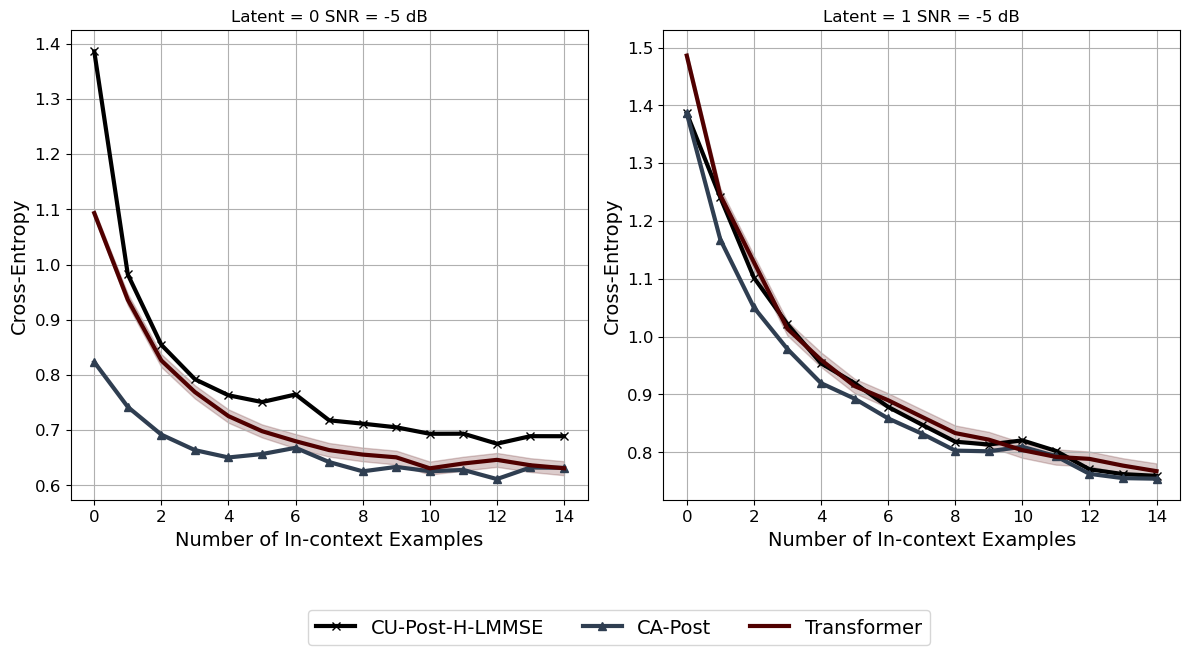

In [20]:
# colors = sns.color_palette("husl", 8)

# colors = mpl.colormaps['Dark2'].colors

# colors = ['#55AA6A', '#556BAA', '#AA9455']

SNR_dB = -5

darkblue =  '#2F3E51'
darkred = '#500000'

lightblue = '#AEB7CF'
customgray = '#707070'

tan = "#D6D3C4"


colors = ['k', darkblue,  darkred]

lws = [3, 3, 3]

# Load the files

CU_xh_MSE = np.load('../Files/CU_xh_MSE_snr_neg5.npy')
# CA_xh_MSE = np.load('../Files/CA_xh_MSE_snr_neg5.npy')
# CU_x_MSE = np.load('../Files/CU_x_MSE_snr_neg5.npy')
CA_x_MSE = np.load('../Files/CA_x_MSE_snr_neg5.npy')

CU_xh_MSE1 = np.load('../Files/CU_xh_MSE1_snr_neg5.npy')
# CA_xh_MSE1 = np.load('../Files/CA_xh_MSE1_snr_neg5.npy')
# CU_x_MSE1 = np.load('../Files/CU_x_MSE1_snr_neg5.npy')
CA_x_MSE1 = np.load('../Files/CA_x_MSE1_snr_neg5.npy')

tf_CE_0 = np.load('../Files/CE_one_ray_tf_detection_time_invariant_snr_neg5.npy')
tf_CE_1 = np.load('../Files/CE_fading_tf_detection_time_invariant_snr_neg5.npy')

max_context_len = len(CU_xh_MSE)


fig, axs = plt.subplots(1, 2, figsize=(6*2, 6), sharex=True)


axs[0].plot(CU_xh_MSE, label='CU-Post-H-LMMSE', color=colors[0], marker='x', lw=lws[0])
# axs[0].plot(CU_x_MSE, label='CU-x-MSE', color='steelblue', marker='o')
# axs[0].plot(CA_xh_MSE, label='CA-xh-MSE', color='seagreen', marker='x')
axs[0].plot(CA_x_MSE, label='CA-Post', color=colors[1], marker='^', lw=lws[1])

lineplot_with_ci(tf_CE_0,
        n_points=max_context_len,
        offset=0,
        label="Transformer",
        ax=axs[0], color=colors[2], lw=lws[2])

# axs[0].plot(np.mean(tf_SEP_0, axis=0), label='Transformer', color='darkred', marker='s')
axs[0].set_title(f'Latent = 0 SNR = {SNR_dB} dB')
axs[0].grid()


# plt.close()

axs[1].plot(CU_xh_MSE1, label='CU-Post-H-LMMSE', color=colors[0], marker='x', lw=lws[0])
# plt.plot(CU_x_MSE1, label='CU-x-MSE', color='steelblue', marker='o')
# plt.plot(CA_xh_MSE1, label='CA-xh-MSE', color='seagreen', marker='x')
axs[1].plot(CA_x_MSE1, label='CA-Post', color=colors[1], marker='^', lw=lws[1])
# axs[1].plot(np.mean(tf_SEP_1, axis=0), label='Transformer', color='darkred', marker='s')

lineplot_with_ci(tf_CE_1,
        n_points=max_context_len,
        offset=0,
        label="Transformer",
        ax=axs[1], color=colors[2], lw=lws[2])

axs[1].set_title(f'Latent = 1 SNR = {SNR_dB} dB')
# axs[1].set_ylim([-5,105])
axs[1].grid()


for ax in axs:
    ax.set_xlabel("Number of In-context Examples", fontsize=14)
    ax.set_ylabel("Cross-Entropy", fontsize=14)
    ax.tick_params(axis='both', which='major', labelsize=12)
#     ax.set_facecolor('whitesmoke')

lines, labels = axs[1].get_legend_handles_labels()
fig.legend(lines, labels, loc='lower center',bbox_to_anchor=(0.52,-0.15), ncol=3, fontsize=14)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig('../Plots/CE_snr_neg5_qpsk_time_invariant.png', dpi=400, bbox_inches='tight')

In [ ]:
import numpy as np

A = np.random.randint(10, size=(10, 3))
B = np.random.randint(3, size=(10,))
result = A[np.arange(A.shape[0]), B]

print('A = ', A)
print('B = ', B)
print('Res = ',  result)